In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, median_absolute_error, r2_score
from scipy.stats import pearsonr
import os
import eli5
import json

In [2]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [3]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
RELATIVE_GAIN_COLUMN_NAME = 'gain_in_r2_score'
SCORE_BEFORE_COLUMN_NAME = 'r2_score_before'
SCORE_AFTER_COLUMN_NAME = 'r2_score_after'
ABSOLUTE_GAIN_COLUMN_NAME = 'absolute_gain_r2'

In [4]:
def print_df(df):
    """Prints entire pandas dataframe.
    """
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.expand_frame_repr', False,
                           'display.max_colwidth', 60):
        print(df)

In [102]:
def get_dataset_name(id_):
    """Connects to Datamart to get the dataset name, given the dataset id.
    """
    
    success = False
    while not success:
        try:
            response = requests.get(
                'http://localhost:8002/metadata/%s'%id_,
            )
            response.raise_for_status()
            success = True
        except Exception as e:
            continue
    
    return json.loads(response.text)['metadata']['name']

In [6]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

## Classification

In [7]:
def create_model(alpha, training_filename, feature_vector, target_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[target_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    clf = RandomForestClassifier(random_state=49, n_estimators=100)
    clf.fit(X_train, y_train)
    
    return clf

In [104]:
def predict_class_for_features(classifier, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate_id'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data['candidate_name'] = test_data['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={target_column: 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    new_test_data = test_data[
        ['candidate_name', 'candidate_id', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']
    ].sort_values('g_r2', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    return (new_test_data, explanations)

In [105]:
def compute_precision_recall(df, print_records=True):
    
    tp_vals = list()
    index_tp = list()
    fp_vals = list()
    index_fp = list()
    tn_vals = list()
    index_tn = list()
    fn_vals = list()
    index_fn = list()
    
    for index, row in df.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tp.append(index)
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fn.append(index)
        elif row['g_r2'] <= 0 and row['class'] == 'gain':
            fp_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_fp.append(index)
        else:
            tn_vals.append([row['candidate_name'], row['g_r2'], row['p(gain)'], row['cf']])
            index_tn.append(index)
            
    tp = len(tp_vals)
    fn = len(fn_vals)
    fp = len(fp_vals)
    tn = len(tn_vals)
            
    columns = ['name', 'g_r2', 'p(gain)', 'cf']
    tp_df = pd.DataFrame(tp_vals, columns=columns, index=index_tp)
    fn_df = pd.DataFrame(fn_vals, columns=columns, index=index_fn)
    fp_df = pd.DataFrame(fp_vals, columns=columns, index=index_fp)
    tn_df = pd.DataFrame(tn_vals, columns=columns, index=index_tn)
            
    print("-- Total:", tp+tn+fp+fn)
    print('')
    print("-- TP:", tp)
    if print_records:
        print_df(tp_df)
    print('')
    print("-- TN:", tn)
    if print_records:
        print_df(tn_df)
    print('')
    print("-- FP:", fp)
    if print_records:
        print_df(fp_df)
    print('')
    print("-- FN:", fn)
    if print_records:
        print_df(fn_df)
    print('')

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [169]:
def predict_class_for_features_and_save(classifier, test_filename, feature_vector, target_column, output_path):

    test_data = pd.read_csv(test_filename)
    
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True, drop=True)
    X_test = test_data[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    predicted_classes = classifier.predict(X_test)
    test_data['class'] = predicted_classes
    
    predicted_proba = classifier.predict_proba(X_test)
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    evals = list()
    for index, row in test_data.iterrows():
        if row[target_column] > 0 and row['class'] == 'gain':
            evals.append('tp')
        elif row[target_column] > 0 and row['class'] == 'loss':
            evals.append('fn')
        elif row[target_column] <= 0 and row['class'] == 'gain':
            evals.append('fp')
        else:
            evals.append('tn')
    test_data['eval'] = evals
    
    test_data.to_csv(output_path, index=False)

In [82]:
def remove_gain_halfway(df):
    
    new_df = df.copy()
    new_df = new_df[(new_df['p(gain)'] <= 0.4) | (new_df['p(gain)'] >= 0.6)]
    
    return new_df

In [11]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

In [172]:
rf_classifier_no_max_pearson_diff = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=list(set(FEATURE_VECTOR).difference(set(['max_pearson_difference']))),
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

## Regression

In [12]:
def create_absolute_gain_column(df, score_before_column, score_after_column, column_name):
    df[column_name] = df[score_after_column] - df[score_before_column]

In [13]:
def create_regression_model_from_df(training_df, feature_vector, target_column):
    """This functions builds a regressor based on the training data (pandas.Dataframe).
    """

    X_train = training_df[feature_vector]
    y_train = training_df[target_column]
    
    regr = RandomForestRegressor(random_state=49, n_estimators=100)
    regr.fit(X_train, y_train)
    
    return regr

In [14]:
def create_regression_model(training_filename, feature_vector, target_column):
    """This functions builds a regressor based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    
    return create_regression_model_from_df(training_data, feature_vector, target_column)

In [15]:
def predict_value_for_features_from_df(regressor, test_df, feature_vector, target_column):
    
    # avoiding overflow
    for col in test_df.select_dtypes([np.number]).columns:
        test_df = test_df[test_df[col] < np.finfo(np.float32).max]
    test_df.reset_index(inplace=True)
    X_test = test_df[feature_vector]
    
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    y_fit = regressor.predict(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(regressor, X_test.iloc[index]))
    
    test_df['predicted'] = y_fit
    test_df['candidate_id'] = test_df['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_df['candidate_name'] = test_df['candidate_id'].apply(
        lambda x: get_dataset_name(x[:x.find('_')])
    )
    test_df.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_df.rename(columns={target_column: 'real'}, inplace=True)
    
    new_test_data = test_df[
#        ['candidate_name', 'candidate_id', 'cf', 'real', 'predicted']
        ['candidate_name', 'cf', 'real', 'predicted']
    ].sort_values('real', ascending=False)
    new_test_data.reset_index(drop=True, inplace=True)
    
    print("Mean Absolute Error: %.4f" % mean_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("Mean Squared Error: %.4f" % mean_squared_error(new_test_data['real'], new_test_data['predicted']))
    print("Median Absolute Error: %.4f" % median_absolute_error(new_test_data['real'], new_test_data['predicted']))
    print("R2 Score: %.4f" % r2_score(new_test_data['real'], new_test_data['predicted']))
    
    return (new_test_data, explanations)

In [16]:
def predict_value_for_features(regressor, test_filename, feature_vector, target_column):

    test_data = pd.read_csv(test_filename)
    
    return predict_value_for_features_from_df(
        regressor,
        test_data,
        feature_vector,
        target_column
    )

In [17]:
rf_regressor = create_regression_model(
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

In [20]:
training_df_with_abolute_column = pd.read_csv('../data/training-for-model.csv')
create_absolute_gain_column(
    training_df_with_abolute_column,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
rf_regressor_abs = create_regression_model_from_df(
    training_df=training_df_with_abolute_column,
    feature_vector=FEATURE_VECTOR,
    target_column=ABSOLUTE_GAIN_COLUMN_NAME
)

## NY Taxi and Vehicle Collision Problem

### Classification

In [88]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [90]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- Total: 76

-- TP: 15
                                                                     name    g_r2  p(gain)      cf  n-col
0                                                        DHS Daily Report 4.43722  0.53000 0.97238     13
1            Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.62000 0.14365      3
2            Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.62000 0.14365      3
3   Performance Metrics - Buildings - Time to Issue Developer Services... 4.02944  0.50000 0.14365      3
4   Performance Metrics - Buildings - Time to Issue Developer Services... 4.02944  0.50000 0.14365      3
6                                 CTA - Ridership - Daily Boarding Totals 2.42632  0.51000 1.00000      4
12                                  Cash Assistance Recipients Since 1955 1.31017  0.55000 0.03315     11
13         Interagency Coordination and Construction Permits Data (MOSYS) 1.28968  0.52000 0.00552      2
14         Interagency

In [100]:
taxi_vehicle_collision_explanations[38]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,candidate_max_kurtosis,0.04616,2266.00267
2,gain,query_target_max_spearman,0.03262,0.23067
3,gain,query_num_of_columns,0.03104,2.00000
4,gain,candidate_target_max_covariance,0.02868,2056489709.77668
5,gain,candidate_max_unique,0.02814,2365.00000
6,gain,candidate_target_max_mutual_info,0.02294,0.18128
7,gain,query_num_of_rows,0.01941,181.00000
8,gain,candidate_max_skewness,0.01270,47.10386
9,gain,candidate_num_rows,0.00550,2365.00000


In [23]:
compute_precision_recall(taxi_vehicle_collision_classes, print_records=False)

-- Total: 76

-- TP: 15

-- TN: 22

-- FP: 23

-- FN: 16

Precision: 0.3947
Recall: 0.4839


In [24]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.4056500620662548

In [25]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

0.08466838554513119

In [26]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [27]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

-1.2299004021137927e-05

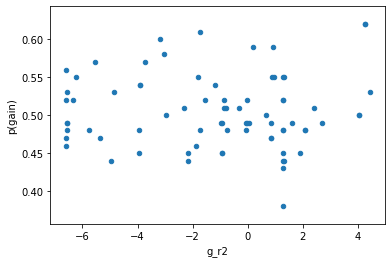

In [28]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [29]:
taxi_vehicle_collision_classes_i = remove_gain_halfway(taxi_vehicle_collision_classes)

In [30]:
compute_precision_recall(taxi_vehicle_collision_classes_i)

-- Total: 5

-- TP: 2
                                                           name    g_r2  p(gain)      cf
1  Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.62000 0.14365
2  Performance Metrics - Buildings - Time to Issue Easy Permits 4.24356  0.62000 0.14365

-- TN: 0
Empty DataFrame
Columns: [name, g_r2, p(gain), cf]
Index: []

-- FP: 2
                           name     g_r2  p(gain)      cf
47         311 Cases by Channel -1.73887  0.61000 0.03315
55  Bikes in Buildings Requests -3.17779  0.60000 0.03315

-- FN: 1
                             name    g_r2  p(gain)      cf
19  NYCHA Citywide Special Events 1.28968  0.38000 0.02762

Precision: 0.5000
Recall: 0.6667


In [31]:
compute_precision_recall(taxi_vehicle_collision_classes_i, print_records=False)

-- Total: 5

-- TP: 2

-- TN: 0

-- FP: 2

-- FN: 1

Precision: 0.5000
Recall: 0.6667


In [32]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'g_r2')

0.8628277794124862

In [33]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'cf', 'p(gain)')

0.5045367099296807

In [34]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes_i, 'g_r2', 'p(gain)')

0.02391727533522356

### Regression

In [35]:
taxi_vehicle_collision_predictions, taxi_vehicle_collision_regr_explanations = predict_value_for_features(
    rf_regressor,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 72.0118
Mean Squared Error: 13613.2250
Median Absolute Error: 13.8157
R2 Score: -1396.3964


In [36]:
print_df(taxi_vehicle_collision_predictions)

                                                           candidate_name      cf     real  predicted
0                                                        DHS Daily Report 0.97238  4.43722  179.42432
1            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    4.19634
2            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  4.24356    4.19634
3   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.28069
4   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  4.02944    0.28069
5                                               Daily Weather Data for NY 1.00000  2.69791  180.61858
6                                 CTA - Ridership - Daily Boarding Totals 1.00000  2.42632  180.87837
7           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365  2.09037   -0.41328
8           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365 

In [37]:
taxi_vehicle_collision_regr_explanations[5]

,target,feature,weight,value
0,y,query_target_max_pearson,398.82819,0.03657
1,y,candidate_target_max_covariance,192.46929,9551887.31111
2,y,candidate_target_max_spearman,128.94593,0.01271
3,y,candidate_max_kurtosis,24.90749,0.35314
4,y,candidate_row_column_ratio,4.76178,124.00000
5,y,<BIAS>,2.00898,1.00000
6,y,candidate_max_skewness,0.34652,0.64483
7,y,query_target_max_covariance,0.23068,176158.30261
8,y,query_target_max_spearman,0.12862,0.23067
9,y,candidate_target_max_mutual_info,0.12682,0.19854


### Regression -- absolute diff in R2 score

In [39]:
taxi_vehicle_collision_records_features = pd.read_csv('taxi-vehicle-collision-records-features')
create_absolute_gain_column(
    taxi_vehicle_collision_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
taxi_vehicle_collision_predictions_abs, taxi_vehicle_collision_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    taxi_vehicle_collision_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.1579
Mean Squared Error: 0.0453
Median Absolute Error: 0.1137
R2 Score: -0.4712


In [40]:
print_df(taxi_vehicle_collision_predictions_abs)

                                                           candidate_name      cf     real  predicted
0                                                        DHS Daily Report 0.97238  0.24945    0.05617
1            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  0.23857    0.10500
2            Performance Metrics - Buildings - Time to Issue Easy Permits 0.14365  0.23857    0.10500
3   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  0.22653    0.04866
4   Performance Metrics - Buildings - Time to Issue Developer Services... 0.14365  0.22653    0.04866
5                                               Daily Weather Data for NY 1.00000  0.15167    0.01480
6                                 CTA - Ridership - Daily Boarding Totals 1.00000  0.13640    0.06480
7           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365  0.11752    0.05477
8           Performance Metrics - Buildings - Time To Issue Green Permits 0.14365 

## College Debt

### Classification

In [41]:
college_debt_classes, college_debt_explanations = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [42]:
compute_precision_recall(college_debt_classes)

-- Total: 41

-- TP: 20
                                                                     name    g_r2  p(gain)      cf
0                              Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.79000 1.00000
1                                    College Scorecard Data - Most Recent 0.72774  0.80000 1.00000
2              Chicago Public Schools - School Profile Information SY1617 0.01031  0.69000 0.00020
3              Chicago Public Schools - School Profile Information SY1718 0.00983  0.69000 0.00020
4                                          Public Pay Telephone Locations 0.00903  0.69000 0.01222
5                                                      Muni Simple Routes 0.00780  0.79000 0.00200
6                 Chicago Public Schools - School Progress Reports SY1819 0.00718  0.69000 0.00020
7                                    Lobbyist Data - Expenditures - Small 0.00703  0.68000 0.00160
8              Chicago Public Schools - School Profile Information SY1819 0.00700  0.

In [43]:
compute_precision_recall(college_debt_classes, print_records=False)

-- Total: 41

-- TP: 20

-- TN: 0

-- FP: 21

-- FN: 0

Precision: 0.4878
Recall: 1.0000


In [44]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

0.7769692883819711

In [45]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

0.522173276732003

In [46]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

0.4333985977390448

### Classification -- ignoring p(gain) between 0.4 and 0.6

In [47]:
college_debt_classes_i = remove_gain_halfway(college_debt_classes)

In [48]:
compute_precision_recall(college_debt_classes_i)

-- Total: 37

-- TP: 18
                                                                     name    g_r2  p(gain)      cf
0                              Most- Recent- Cohorts- Scorecard- Elements 0.80812  0.79000 1.00000
1                                    College Scorecard Data - Most Recent 0.72774  0.80000 1.00000
2              Chicago Public Schools - School Profile Information SY1617 0.01031  0.69000 0.00020
3              Chicago Public Schools - School Profile Information SY1718 0.00983  0.69000 0.00020
4                                          Public Pay Telephone Locations 0.00903  0.69000 0.01222
5                                                      Muni Simple Routes 0.00780  0.79000 0.00200
6                 Chicago Public Schools - School Progress Reports SY1819 0.00718  0.69000 0.00020
7                                    Lobbyist Data - Expenditures - Small 0.00703  0.68000 0.00160
8              Chicago Public Schools - School Profile Information SY1819 0.00700  0.

In [49]:
compute_precision_recall(college_debt_classes_i, print_records=False)

-- Total: 37

-- TP: 18

-- TN: 0

-- FP: 19

-- FN: 0

Precision: 0.4865
Recall: 1.0000


In [50]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_i, 'cf', 'g_r2')

0.7779191645634217

In [51]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'cf', 'p(gain)')

0.6174432900952249

In [52]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_i, 'g_r2', 'p(gain)')

0.512570002934417

### Classification (Single Column)

In [151]:
college_debt_classes_single_column, college_debt_explanations_single_column = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [152]:
compute_precision_recall(college_debt_classes_single_column)

-- Total: 1103

-- TP: 130
                                           name    g_r2  p(gain)      cf
0    Most- Recent- Cohorts- Scorecard- Elements 0.36326  0.79000 1.00000
1          College Scorecard Data - Most Recent 0.29249  0.85000 0.93427
2    Most- Recent- Cohorts- Scorecard- Elements 0.29249  0.85000 0.93427
3    Most- Recent- Cohorts- Scorecard- Elements 0.28539  0.80000 0.40000
4          College Scorecard Data - Most Recent 0.28539  0.80000 0.40000
5          College Scorecard Data - Most Recent 0.27195  0.71000 1.00000
6    Most- Recent- Cohorts- Scorecard- Elements 0.27195  0.71000 1.00000
7          College Scorecard Data - Most Recent 0.24433  0.63000 1.00000
8    Most- Recent- Cohorts- Scorecard- Elements 0.24433  0.63000 1.00000
9    Most- Recent- Cohorts- Scorecard- Elements 0.19484  0.69000 0.45230
10         College Scorecard Data - Most Recent 0.19484  0.69000 0.45230
11         College Scorecard Data - Most Recent 0.15060  0.78000 0.93427
12   Most- Recent- Cohor

In [180]:
college_debt_classes_single_column.iloc[130]['candidate_id']

'datamart.upload.a817349748524c618bec5505f46feaef_UNITID_ACTWR75'

In [181]:
college_debt_classes_single_column.iloc[131]['candidate_id']

'datamart.socrata.data-wa-gov.wajg-ig9g_UNITID_ACTWR75'

In [182]:
college_debt_classes_single_column.iloc[132]['candidate_id']

'datamart.socrata.data-cityofnewyork-us.bzxi-2tsw_Building ID_Lot'

In [171]:
college_debt_explanations_single_column[130]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.10408,3512.00000
2,gain,query_target_max_covariance,0.03053,23744.18583
3,gain,max_pearson_difference,0.02485,0.45175
4,gain,query_max_skewness,0.02255,5.83849
5,gain,query_target_max_pearson,0.02165,0.45973
6,gain,query_target_max_spearman,0.02133,0.45678
7,gain,query_num_of_rows,0.01936,4990.00000
8,gain,candidate_target_max_mutual_info,0.01681,0.01304
9,gain,candidate_max_kurtosis,0.00735,156.63649


In [153]:
compute_precision_recall(college_debt_classes_single_column, print_records=False)

-- Total: 1103

-- TP: 130

-- TN: 0

-- FP: 973

-- FN: 0

Precision: 0.1179
Recall: 1.0000


In [154]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_single_column, 'cf', 'g_r2')

0.5470801641189097

In [155]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_single_column, 'cf', 'p(gain)')

0.11222329413835062

In [156]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_single_column, 'g_r2', 'p(gain)')

0.05622571508236928

In [170]:
predict_class_for_features_and_save(
    rf_classifier,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME,
    'college-debt-records-features-single-column-w-class'
)

In [173]:
(college_debt_classes_single_column_no_max_pearson_diff,
 college_debt_explanations_single_column_no_max_pearson_diff) = predict_class_for_features(
    rf_classifier_no_max_pearson_diff,
    'college-debt-records-features-single-column',
    list(set(FEATURE_VECTOR).difference(set(['max_pearson_difference']))),
    RELATIVE_GAIN_COLUMN_NAME
)

In [175]:
compute_precision_recall(college_debt_classes_single_column_no_max_pearson_diff)

-- Total: 1103

-- TP: 130
                                           name    g_r2  p(gain)      cf
0    Most- Recent- Cohorts- Scorecard- Elements 0.36326  0.86000 1.00000
1          College Scorecard Data - Most Recent 0.29249  0.89000 0.93427
2    Most- Recent- Cohorts- Scorecard- Elements 0.29249  0.89000 0.93427
3    Most- Recent- Cohorts- Scorecard- Elements 0.28539  0.70000 0.40000
4          College Scorecard Data - Most Recent 0.28539  0.70000 0.40000
5          College Scorecard Data - Most Recent 0.27195  0.73000 1.00000
6    Most- Recent- Cohorts- Scorecard- Elements 0.27195  0.73000 1.00000
7          College Scorecard Data - Most Recent 0.24433  0.70000 1.00000
8    Most- Recent- Cohorts- Scorecard- Elements 0.24433  0.70000 1.00000
9    Most- Recent- Cohorts- Scorecard- Elements 0.19484  0.66000 0.45230
10         College Scorecard Data - Most Recent 0.19484  0.66000 0.45230
11         College Scorecard Data - Most Recent 0.15060  0.78000 0.93427
12   Most- Recent- Cohor

In [176]:
compute_precision_recall(college_debt_classes_single_column_no_max_pearson_diff, print_records=False)

-- Total: 1103

-- TP: 130

-- TN: 0

-- FP: 973

-- FN: 0

Precision: 0.1179
Recall: 1.0000


In [177]:
college_debt_explanations_single_column_no_max_pearson_diff[130]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.10706,3512.00000
2,gain,query_target_max_mutual_info,0.02908,0.66787
3,gain,candidate_max_skewness,0.02138,11.66659
4,gain,query_row_column_ratio,0.01763,415.83333
5,gain,query_num_of_rows,0.01525,4990.00000
6,gain,query_max_kurtosis,0.01065,50.96627
7,gain,query_target_max_spearman,0.01012,0.45678
8,gain,query_target_max_pearson,0.00951,0.45973
9,gain,query_target_max_covariance,0.00621,23744.18583


### Classification (Single Column) -- ignoring p(gain) between 0.4 and 0.6

In [157]:
college_debt_classes_single_column_i = remove_gain_halfway(college_debt_classes_single_column)

In [158]:
compute_precision_recall(college_debt_classes_single_column_i)

-- Total: 1101

-- TP: 128
                                           name    g_r2  p(gain)      cf
0    Most- Recent- Cohorts- Scorecard- Elements 0.36326  0.79000 1.00000
1          College Scorecard Data - Most Recent 0.29249  0.85000 0.93427
2    Most- Recent- Cohorts- Scorecard- Elements 0.29249  0.85000 0.93427
3    Most- Recent- Cohorts- Scorecard- Elements 0.28539  0.80000 0.40000
4          College Scorecard Data - Most Recent 0.28539  0.80000 0.40000
5          College Scorecard Data - Most Recent 0.27195  0.71000 1.00000
6    Most- Recent- Cohorts- Scorecard- Elements 0.27195  0.71000 1.00000
7          College Scorecard Data - Most Recent 0.24433  0.63000 1.00000
8    Most- Recent- Cohorts- Scorecard- Elements 0.24433  0.63000 1.00000
9    Most- Recent- Cohorts- Scorecard- Elements 0.19484  0.69000 0.45230
10         College Scorecard Data - Most Recent 0.19484  0.69000 0.45230
11         College Scorecard Data - Most Recent 0.15060  0.78000 0.93427
12   Most- Recent- Cohor

In [159]:
compute_precision_recall(college_debt_classes_single_column_i, print_records=False)

-- Total: 1101

-- TP: 128

-- TN: 0

-- FP: 973

-- FN: 0

Precision: 0.1163
Recall: 1.0000


In [160]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes_single_column_i, 'cf', 'g_r2')

0.5444842440386586

In [161]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes_single_column_i, 'cf', 'p(gain)')

0.12992032400782938

In [162]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes_single_column_i, 'g_r2', 'p(gain)')

0.0649802131608488

### Regression

In [53]:
college_debt_predictions, college_debt_regr_explanations = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.2987
Mean Squared Error: 0.2997
Median Absolute Error: 0.0683
R2 Score: -8.3004


In [54]:
print_df(college_debt_predictions)

                                                           candidate_name      cf     real  predicted
0                              Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.80812    0.03781
1                                    College Scorecard Data - Most Recent 1.00000  0.72774    0.01911
2              Chicago Public Schools - School Profile Information SY1617 0.00020  0.01031    0.05830
3              Chicago Public Schools - School Profile Information SY1718 0.00020  0.00983    0.05830
4                                          Public Pay Telephone Locations 0.01222  0.00903   -0.02792
5                                                      Muni Simple Routes 0.00200  0.00780   -0.04669
6                 Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00718    0.05847
7                                    Lobbyist Data - Expenditures - Small 0.00160  0.00703   -0.04944
8              Chicago Public Schools - School Profile Information SY1819 0.00020 

### Regression -- absolute diff in R2 score

In [55]:
college_debt_records_features = pd.read_csv('college-debt-records-features')
create_absolute_gain_column(
    college_debt_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
college_debt_predictions_abs, college_debt_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    college_debt_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.0343
Mean Squared Error: 0.0038
Median Absolute Error: 0.0288
R2 Score: 0.2567


In [56]:
print_df(college_debt_predictions_abs)

                                                           candidate_name      cf     real  predicted
0                              Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.31974    0.08498
1                                    College Scorecard Data - Most Recent 1.00000  0.28793    0.03201
2              Chicago Public Schools - School Profile Information SY1617 0.00020  0.00408    0.01734
3              Chicago Public Schools - School Profile Information SY1718 0.00020  0.00389    0.01737
4                                          Public Pay Telephone Locations 0.01222  0.00357    0.00138
5                                                      Muni Simple Routes 0.00200  0.00309   -0.00080
6                 Chicago Public Schools - School Progress Reports SY1819 0.00020  0.00284    0.01698
7                                    Lobbyist Data - Expenditures - Small 0.00160  0.00278    0.00135
8              Chicago Public Schools - School Profile Information SY1819 0.00020 

### Regression (Single Column)

In [163]:
college_debt_predictions_single_column, college_debt_regr_explanations_single_column = predict_value_for_features(
    rf_regressor,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.0699
Mean Squared Error: 0.0107
Median Absolute Error: 0.0523
R2 Score: -2.0725


In [164]:
print_df(college_debt_predictions_single_column)

                                                             candidate_name      cf     real  predicted
0                                Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.36326    0.00898
1                                      College Scorecard Data - Most Recent 0.93427  0.29249    0.30284
2                                Most- Recent- Cohorts- Scorecard- Elements 0.93427  0.29249    0.30284
3                                Most- Recent- Cohorts- Scorecard- Elements 0.40000  0.28539    0.08715
4                                      College Scorecard Data - Most Recent 0.40000  0.28539    0.08715
5                                      College Scorecard Data - Most Recent 1.00000  0.27195    0.00844
6                                Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.27195    0.00844
7                                      College Scorecard Data - Most Recent 1.00000  0.24433   -0.07790
8                                Most- Recent- Cohorts- Scorecar

### Regression (Single Column) -- absolute diff in R2 score

In [165]:
college_debt_records_features_single_column = pd.read_csv('college-debt-records-features-single-column')
create_absolute_gain_column(
    college_debt_records_features_single_column,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
college_debt_predictions_abs_single_column, college_debt_regr_explanations_abs_single_column = predict_value_for_features_from_df(
    rf_regressor_abs,
    college_debt_records_features_single_column,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)


Mean Absolute Error: 0.0256
Mean Squared Error: 0.0011
Median Absolute Error: 0.0234
R2 Score: -0.9278


In [166]:
print_df(college_debt_predictions_abs_single_column)

                                                             candidate_name      cf     real  predicted
0                                Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.14373    0.04487
1                                      College Scorecard Data - Most Recent 0.93427  0.11572    0.02245
2                                Most- Recent- Cohorts- Scorecard- Elements 0.93427  0.11572    0.02245
3                                Most- Recent- Cohorts- Scorecard- Elements 0.40000  0.11292    0.01794
4                                      College Scorecard Data - Most Recent 0.40000  0.11292    0.01794
5                                      College Scorecard Data - Most Recent 1.00000  0.10760    0.01390
6                                Most- Recent- Cohorts- Scorecard- Elements 1.00000  0.10760    0.01390
7                                      College Scorecard Data - Most Recent 1.00000  0.09667    0.01587
8                                Most- Recent- Cohorts- Scorecar

## Poverty Estimation

### Classification

In [57]:
poverty_estimation_classes, poverty_estimation_explanations = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [58]:
compute_precision_recall(poverty_estimation_classes)

-- Total: 2231

-- TP: 292
                                                                      name    g_r2  p(gain)      cf
0                                       State WASL Scores by Subgroup_2008 0.03277  0.57000 0.00032
1                                   State MSP-HSPE Scores by Subgroup_2009 0.03277  0.63000 0.00064
2                                   State MSP-HSPE Scores by Subgroup_2010 0.03140  0.57000 0.00191
3                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.57000 0.00032
4                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.57000 0.00032
5                                 2013 - 2018 Demographic Snapshot Borough 0.02960  0.57000 0.00032
6                                    County Agricultural Districts Profile 0.02846  0.62000 0.00159
7                                                   Unemployment in the US 0.02825  0.56000 1.00000
8                                       CTE Demographic Data by State_201

In [75]:
poverty_estimation_explanations[301]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.10265,2790.00000
2,gain,candidate_target_max_mutual_info,0.03373,0.07327
3,gain,query_target_max_spearman,0.02942,0.69943
4,gain,candidate_row_column_ratio,0.02379,8.00000
5,gain,candidate_num_rows,0.02100,672.00000
6,gain,candidate_max_skewness,0.01158,8.24316
7,gain,candidate_max_kurtosis,0.01019,72.01031
8,gain,query_num_of_rows,0.00565,3136.00000
9,gain,containment_fraction,0.00416,0.00510


In [59]:
compute_precision_recall(poverty_estimation_classes, print_records=False)

-- Total: 2231

-- TP: 292

-- TN: 163

-- FP: 1767

-- FN: 9

Precision: 0.1418
Recall: 0.9701


In [60]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.0539733970678087

In [61]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

-0.05718651434814721

In [62]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.12920532108583613

In [63]:
poverty_estimation_explanations[0]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.09801,2790.00000
2,gain,candidate_target_max_mutual_info,0.05079,0.03312
3,gain,candidate_row_column_ratio,0.03782,17.36364
4,gain,query_target_max_spearman,0.02276,0.69943
5,gain,candidate_max_skewness,0.01310,5.51549
6,gain,query_num_of_rows,0.01301,3136.00000
7,gain,containment_fraction,0.01264,0.00096
8,gain,max_pearson_difference,0.00950,0.29249
9,gain,candidate_num_rows,0.00588,191.00000


### Classification -- ignoring p(gain) between 0.4 and 0.6

In [64]:
poverty_estimation_classes_i = remove_gain_halfway(poverty_estimation_classes)

In [65]:
compute_precision_recall(poverty_estimation_classes_i)

-- Total: 598

-- TP: 116
                                                                      name    g_r2  p(gain)      cf
1                                   State MSP-HSPE Scores by Subgroup_2009 0.03277  0.63000 0.00064
6                                    County Agricultural Districts Profile 0.02846  0.62000 0.00159
17                                       State EOC scores by Subgroup_2015 0.02161  0.62000 0.00064
19                                Electric Vehicle Population Size History 0.02079  0.61000 0.00159
20   State University of New York (SUNY) Trends in Enrollment of Studen... 0.01995  0.64000 0.00128
21                     Washington Anadromous Fish Harvest Data 1974 - 2012 0.01983  0.61000 0.00064
22   Broadband Adoption and Computer Use by year, state, demographic ch... 0.01976  0.62000 0.00064
38                                              Total Prosser Run 12182014 0.01822  0.63000 0.00064
40                               Libraries -  2015 Circulation by Location

                                                                       name     g_r2  p(gain)      cf
302                                  State MSP-HSPE Scores by Subgroup_2013 -0.00007  0.61000 0.00287
304   2006 - 2012 English Language Arts (ELA) Test Results - Citywide - SWD -0.00031  0.62000 0.00159
318   WAOFM - Congressional Districts - Table 2: Census 2010 Population ... -0.00090  0.64000 0.00096
320   2006 - 2011 NYS Math Test Results by Grade - Citywide - by Disabil... -0.00102  0.60000 0.00191
321                          2006 - 2012 Math Test Results - Citywide - SWD -0.00102  0.60000 0.00223
323   2006 - 2011  English Language Arts (ELA) Test Results by Grade - C... -0.00119  0.62000 0.00096
325                                   Libraries - 2015 Visitors by Location -0.00142  0.60000 0.00096
329   2006 - 2012 English Language Arts (ELA) Test Results - Citywide - ... -0.00168  0.61000 0.00096
330                          Libraries - 2012 Computer Sessions by Location -0.001

In [76]:
poverty_estimation_explanations[302]

,target,feature,weight,value
0,gain,<BIAS>,0.55715,1.00000
1,gain,query_max_unique,0.09654,2790.00000
2,gain,query_target_max_spearman,0.04177,0.69943
3,gain,candidate_row_column_ratio,0.01375,4.45000
4,gain,candidate_target_max_covariance,0.01192,1599199.15112
5,gain,query_num_of_rows,0.01065,3136.00000
6,gain,candidate_target_max_mutual_info,0.00806,1.23047
7,gain,containment_fraction,0.00610,0.00128
8,gain,candidate_max_kurtosis,0.00529,98.68518
9,gain,candidate_num_rows,0.00492,267.00000


In [66]:
compute_precision_recall(poverty_estimation_classes_i, print_records=False)

-- Total: 598

-- TP: 116

-- TN: 0

-- FP: 482

-- FN: 0

Precision: 0.1940
Recall: 1.0000


In [67]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes_i, 'cf', 'g_r2')

0.0023324321260950152

In [68]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'cf', 'p(gain)')

-0.0608150813403876

In [69]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes_i, 'g_r2', 'p(gain)')

-0.013285755846327728

### Regression

In [70]:
poverty_estimation_predictions, poverty_estimation_regr_explanations = predict_value_for_features(
    rf_regressor,
    'poverty-estimation-records-features',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 1.8028
Mean Squared Error: 343.4397
Median Absolute Error: 0.1687
R2 Score: -20655.3785


In [71]:
print_df(poverty_estimation_predictions)

                                                             candidate_name      cf     real  predicted
0                                        State WASL Scores by Subgroup_2008 0.00032  0.03277   -0.04034
1                                    State MSP-HSPE Scores by Subgroup_2009 0.00064  0.03277   -0.18331
2                                    State MSP-HSPE Scores by Subgroup_2010 0.00191  0.03140   -0.15572
3                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    0.00811
4                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    0.00811
5                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.02960    0.00811
6                                     County Agricultural Districts Profile 0.00159  0.02846   -0.22466
7                                                    Unemployment in the US 1.00000  0.02825    0.18439
8                                        CTE Demographic Data by

### Regression -- absolute diff in R2 score

In [72]:
poverty_estimation_records_features = pd.read_csv('poverty-estimation-records-features')
create_absolute_gain_column(
    poverty_estimation_records_features,
    SCORE_BEFORE_COLUMN_NAME,
    SCORE_AFTER_COLUMN_NAME,
    ABSOLUTE_GAIN_COLUMN_NAME
)
poverty_estimation_predictions_abs, poverty_estimation_regr_explanations_abs = predict_value_for_features_from_df(
    rf_regressor_abs,
    poverty_estimation_records_features,
    FEATURE_VECTOR,
    ABSOLUTE_GAIN_COLUMN_NAME
)

Mean Absolute Error: 0.0933
Mean Squared Error: 0.0112
Median Absolute Error: 0.1191
R2 Score: -3.1818


In [73]:
print_df(poverty_estimation_predictions_abs)

                                                             candidate_name      cf     real  predicted
0                                        State WASL Scores by Subgroup_2008 0.00032  0.01317   -0.00069
1                                    State MSP-HSPE Scores by Subgroup_2009 0.00064  0.01317   -0.00220
2                                    State MSP-HSPE Scores by Subgroup_2010 0.00191  0.01262    0.00288
3                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00027
4                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00027
5                                  2013 - 2018 Demographic Snapshot Borough 0.00032  0.01190    0.00027
6                                     County Agricultural Districts Profile 0.00159  0.01144    0.00185
7                                                    Unemployment in the US 1.00000  0.01135    0.02746
8                                        CTE Demographic Data by

## Learning and Predicting Using Only the Use Cases

### Training with Poverty Estimation

In [ ]:
rf_classifier_poverty_estimation = create_model(
    alpha=0,
    training_filename='poverty-estimation-records-features-single-column',
    feature_vector=FEATURE_VECTOR,
    target_column=RELATIVE_GAIN_COLUMN_NAME
)

### Testing: College Debt

In [ ]:
college_debt_classes_poverty, college_debt_explanations_poverty = predict_class_for_features(
    rf_classifier_poverty_estimation,
    'college-debt-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [ ]:
compute_precision_recall(college_debt_classes_poverty)

In [ ]:
compute_precision_recall(college_debt_classes_poverty, print_records=False)

### Testing: Taxi and Vehicle Collisions

In [ ]:
taxi_vehicle_collisions_classes_poverty, taxi_vehicle_collisions_explanations_poverty = predict_class_for_features(
    rf_classifier_poverty_estimation,
    'taxi-vehicle-collision-records-features-single-column',
    FEATURE_VECTOR,
    RELATIVE_GAIN_COLUMN_NAME
)

In [ ]:
compute_precision_recall(taxi_vehicle_collisions_classes_poverty)

In [ ]:
compute_precision_recall(taxi_vehicle_collisions_classes_poverty, print_records=False)